# Data Preparation
## Load multiple CSV files and combine them into a single DataFrame for further analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Liste der CSV-Dateien
files = [
    "250503_flightradar_prepared.csv",
    "250502_flightradar_prepared.csv",
    "250501_flightradar_prepared.csv",
    "250430_flightradar_prepared.csv",
    "250429_flightradar_prepared.csv",
    "250428_flightradar_prepared.csv"
]

# Alle Dateien einlesen und in einem DataFrame zusammenführen
flightradar_all = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Kontrolle
print(flightradar_all.head())
print("\n")
print(flightradar_all.dtypes)
print(flightradar_all.shape) 


  DESTINATION_CLEAN IATA_CODE   AIRLINE_CLEAN AIRCRAFT_SHORT  CANCELED  \
0           Antalya       AYT   Edelweiss Air           A320     False   
1          Pristina       PRN  Chair Airlines           A320     False   
2          Hurghada       HRG   Edelweiss Air           A320     False   
3           Catania       CTA           Swiss           A320     False   
4          Tenerife       TFS   Edelweiss Air           A320     False   

              DATETIME DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  
0  2025-05-03 05:45:00       06:00  2025-05-03 06:00:00             15  
1  2025-05-03 05:45:00       06:02  2025-05-03 06:02:00             17  
2  2025-05-03 06:00:00       06:05  2025-05-03 06:05:00              5  
3  2025-05-03 06:00:00       06:07  2025-05-03 06:07:00              7  
4  2025-05-03 06:10:00       06:31  2025-05-03 06:31:00             21  


DESTINATION_CLEAN    object
IATA_CODE            object
AIRLINE_CLEAN        object
AIRCRAFT_SHORT       object
CAN

## Import weather dataset for analysis

In [2]:
# CSV‑Datei laden (im gleichen Verzeichnis wie dein Notebook)
weather = pd.read_csv("weather.csv")

# Erstmal Überblick verschaffen
print(weather.head())        # erste 5 Zeilen
print("\n")
print(weather.dtypes)        # Datentypen der Spalten
print(weather.shape)         # (Anzahl Zeilen, Anzahl Spalten)

                  time  temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
0  2025-04-28 00:00:00   9.9   8.3    90   0.0   NaN   293   2.0  15.0   
1  2025-04-28 01:00:00   8.4   8.0    97   0.0   NaN   276   5.0   9.0   
2  2025-04-28 02:00:00   8.2   7.8    97   0.0   NaN   283   7.0  13.0   
3  2025-04-28 03:00:00   7.8   7.0    95   0.0   NaN   304   3.0   7.0   
4  2025-04-28 04:00:00   5.8   5.5    98   0.0   NaN   306   4.0   6.0   

     pres  tsun  coco  
0  1024.8   NaN     2  
1  1025.0   NaN     2  
2  1024.8   NaN     2  
3  1024.7   NaN     5  
4  1025.1   NaN     5  


time     object
temp    float64
dwpt    float64
rhum      int64
prcp    float64
snow    float64
wdir      int64
wspd    float64
wpgt    float64
pres    float64
tsun    float64
coco      int64
dtype: object
(144, 12)


## Merge the two datasets: `flightradar_all` and `weather`


In [3]:
# Zeitspalten in datetime umwandeln
flightradar_all["DATETIME"] = pd.to_datetime(flightradar_all["DATETIME"])
weather["time"] = pd.to_datetime(weather["time"])

# Neue Spalte mit gerundeter Stunde erstellen
flightradar_all["DATETIME_HOUR"] = flightradar_all["DATETIME"].dt.floor("H")

# Sortieren (wichtig für merge_asof)
flightradar_all = flightradar_all.sort_values("DATETIME_HOUR")
weather = weather.sort_values("time")

# Nur relevante Wetterspalten auswählen
weather_subset = weather[["time", "temp", "snow", "coco"]]

# Merge durchführen
merged = pd.merge_asof(
    flightradar_all,
    weather_subset,
    left_on="DATETIME_HOUR",
    right_on="time",
    direction="nearest"
)

# Ergebnis prüfen
print(merged.head(10))


   DESTINATION_CLEAN IATA_CODE     AIRLINE_CLEAN AIRCRAFT_SHORT  CANCELED  \
0            Larnaca       LCA     Edelweiss Air           A320     False   
1           Pristina       PRN    Chair Airlines           A319     False   
2              Olbia       OLB     Edelweiss Air           A320     False   
3           Pristina       PRN     Edelweiss Air           A359     False   
4             Madrid       MAD  Helvetic Airways           E295     False   
5           Belgrade       BEG             Swiss           BCS3     False   
6             London       LCY             Swiss           BCS1     False   
7  Palma de Mallorca       PMI             Swiss           A321     False   
8           Brindisi       BDS             Swiss           A320     False   
9           Hurghada       HRG    Chair Airlines           A320     False   

             DATETIME DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  \
0 2025-04-28 05:45:00       06:02  2025-04-28 06:02:00             17   
1 2025

/tmp/ipykernel_4260/1224224613.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  flightradar_all["DATETIME_HOUR"] = flightradar_all["DATETIME"].dt.floor("H")


## Creating a New DataFrame with Selected Columns

In [4]:
# Create a new DataFrame with selected columns
zrh_flightdelay = merged[[  
    "DESTINATION_CLEAN",  
    "IATA_CODE",  
    "AIRLINE_CLEAN",  
    "AIRCRAFT_SHORT",    
    "DATETIME",  
    "DEPART_TIME",  
    "DEPART_DATETIME",  
    "DELAY_MINUTES",  
    "coco",    
    "temp"  
]].copy()

# Rename columns
zrh_flightdelay.rename(columns={
    "DESTINATION_CLEAN": "DESTINATION",
    "AIRLINE_CLEAN": "AIRLINE",
    "AIRCRAFT_SHORT": "AIRCRAFT",
    "temp": "TEMP",
    "coco": "WEATHER"
}, inplace=True)

# Check the result
print(zrh_flightdelay.head(10))
print("\n")
print(zrh_flightdelay.dtypes)
print(zrh_flightdelay.shape)


         DESTINATION IATA_CODE           AIRLINE AIRCRAFT            DATETIME  \
0            Larnaca       LCA     Edelweiss Air     A320 2025-04-28 05:45:00   
1           Pristina       PRN    Chair Airlines     A319 2025-04-28 05:45:00   
2              Olbia       OLB     Edelweiss Air     A320 2025-04-28 06:25:00   
3           Pristina       PRN     Edelweiss Air     A359 2025-04-28 06:30:00   
4             Madrid       MAD  Helvetic Airways     E295 2025-04-28 06:55:00   
5           Belgrade       BEG             Swiss     BCS3 2025-04-28 06:55:00   
6             London       LCY             Swiss     BCS1 2025-04-28 06:55:00   
7  Palma de Mallorca       PMI             Swiss     A321 2025-04-28 06:50:00   
8           Brindisi       BDS             Swiss     A320 2025-04-28 06:50:00   
9           Hurghada       HRG    Chair Airlines     A320 2025-04-28 06:45:00   

  DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  WEATHER  TEMP  
0       06:02  2025-04-28 06:02:00       

## Display the merged DataFrame

In [5]:
zrh_flightdelay.head(50)

,DESTINATION,IATA_CODE,AIRLINE,AIRCRAFT,DATETIME,DEPART_TIME,DEPART_DATETIME,DELAY_MINUTES,WEATHER,TEMP
0,Larnaca,LCA,Edelweiss Air,A320,2025-04-28 05:45:00,06:02,2025-04-28 06:02:00,17,5,5.4
1,Pristina,PRN,Chair Airlines,A319,2025-04-28 05:45:00,06:00,2025-04-28 06:00:00,15,5,5.4
2,Olbia,OLB,Edelweiss Air,A320,2025-04-28 06:25:00,06:45,2025-04-28 06:45:00,20,5,6.4
3,Pristina,PRN,Edelweiss Air,A359,2025-04-28 06:30:00,06:38,2025-04-28 06:38:00,8,5,6.4
4,Madrid,MAD,Helvetic Airways,E295,2025-04-28 06:55:00,07:13,2025-04-28 07:13:00,18,5,6.4
5,Belgrade,BEG,Swiss,BCS3,2025-04-28 06:55:00,07:14,2025-04-28 07:14:00,19,5,6.4
6,London,LCY,Swiss,BCS1,2025-04-28 06:55:00,07:34,2025-04-28 07:34:00,39,5,6.4
7,Palma de Mallorca,PMI,Swiss,A321,2025-04-28 06:50:00,07:11,2025-04-28 07:11:00,21,5,6.4
8,Brindisi,BDS,Swiss,A320,2025-04-28 06:50:00,07:17,2025-04-28 07:17:00,27,5,6.4
9,Hurghada,HRG,Chair Airlines,A320,2025-04-28 06:45:00,06:52,2025-04-28 06:52:00,7,5,6.4


## Count missing values in columns

In [6]:
# Count missing values per column
print(zrh_flightdelay.isnull().sum())

# Total number of missing values in the DataFrame
print("Total missing values:", zrh_flightdelay.isnull().sum().sum())

DESTINATION        0
IATA_CODE          0
AIRLINE            0
AIRCRAFT           0
DATETIME           0
DEPART_TIME        0
DEPART_DATETIME    0
DELAY_MINUTES      0
WEATHER            0
TEMP               0
dtype: int64
Total missing values: 0


## Show rows with missing values in the DataFrame

In [7]:
# Filter rows with any missing values
missing_rows = zrh_flightdelay[zrh_flightdelay.isnull().any(axis=1)]

# Display rows with missing values
print(missing_rows)


Empty DataFrame
Columns: [DESTINATION, IATA_CODE, AIRLINE, AIRCRAFT, DATETIME, DEPART_TIME, DEPART_DATETIME, DELAY_MINUTES, WEATHER, TEMP]
Index: []


## Check for duplicate rows in the DataFrame and display them if any exist

In [8]:
# Duplikate prüfen
duplicates = zrh_flightdelay[zrh_flightdelay.duplicated()]

# Duplikate anzeigen (falls vorhanden)
print(duplicates)

# Anzahl der Duplikate
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Empty DataFrame
Columns: [DESTINATION, IATA_CODE, AIRLINE, AIRCRAFT, DATETIME, DEPART_TIME, DEPART_DATETIME, DELAY_MINUTES, WEATHER, TEMP]
Index: []
Number of duplicate rows: 0


# Exploratory Data Analysis (EDA)

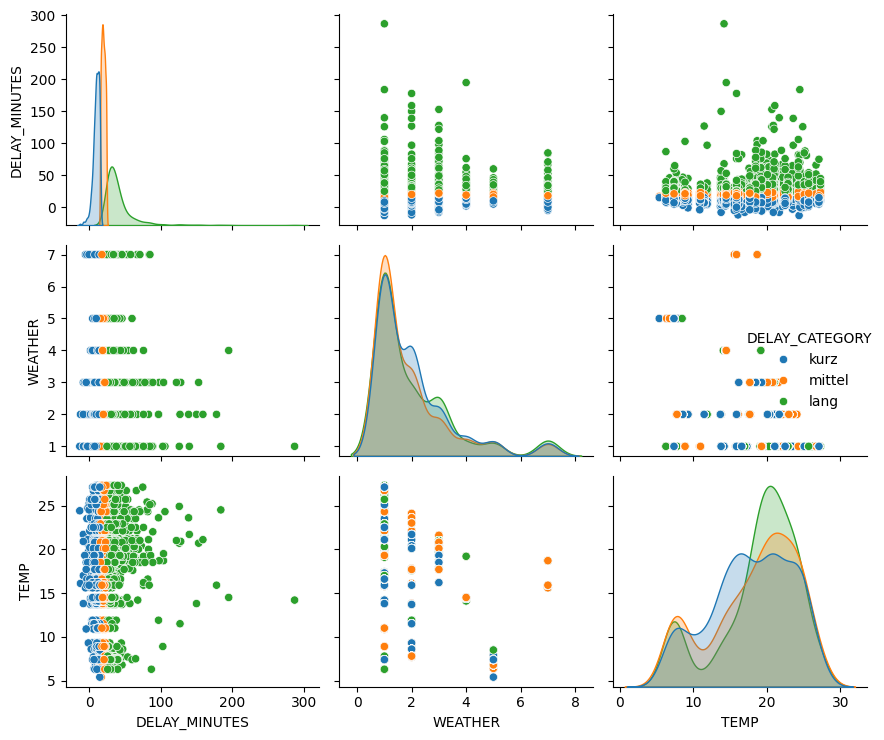

In [9]:
# Relevante Features auswählen
features = ["DELAY_MINUTES", "WEATHER", "TEMP"]
df_selected = zrh_flightdelay[features].copy()

# Optional: Delay in Kategorien einteilen (für farbliche Unterscheidung)
df_selected["DELAY_CATEGORY"] = pd.qcut(df_selected["DELAY_MINUTES"], q=3, labels=["kurz", "mittel", "lang"])

# Pairplot erstellen
sns.pairplot(df_selected, hue="DELAY_CATEGORY")
plt.tight_layout()
plt.show()


## Top 20 most frequent airlines from ZRH

In [10]:
# Anzahl der Flüge pro Airline (Top 20)
top_airline_counts = zrh_flightdelay["AIRLINE"].value_counts().nlargest(20)

# Ausgabe anzeigen
print(top_airline_counts)


AIRLINE
Swiss                712
Helvetic Airways     299
Edelweiss Air        183
Air Baltic           135
easyJet               73
Eurowings             55
British Airways       40
NetJets Europe        38
Chair Airlines        36
KLM                   35
Lufthansa             26
Turkish Airlines      24
Austrian Airlines     21
TAP Air Portugal      20
Iberia                20
Pegasus               20
United Airlines       20
SAS                   18
SunExpress            18
Air France            17
Name: count, dtype: int64


## Flight delays for the top airlines

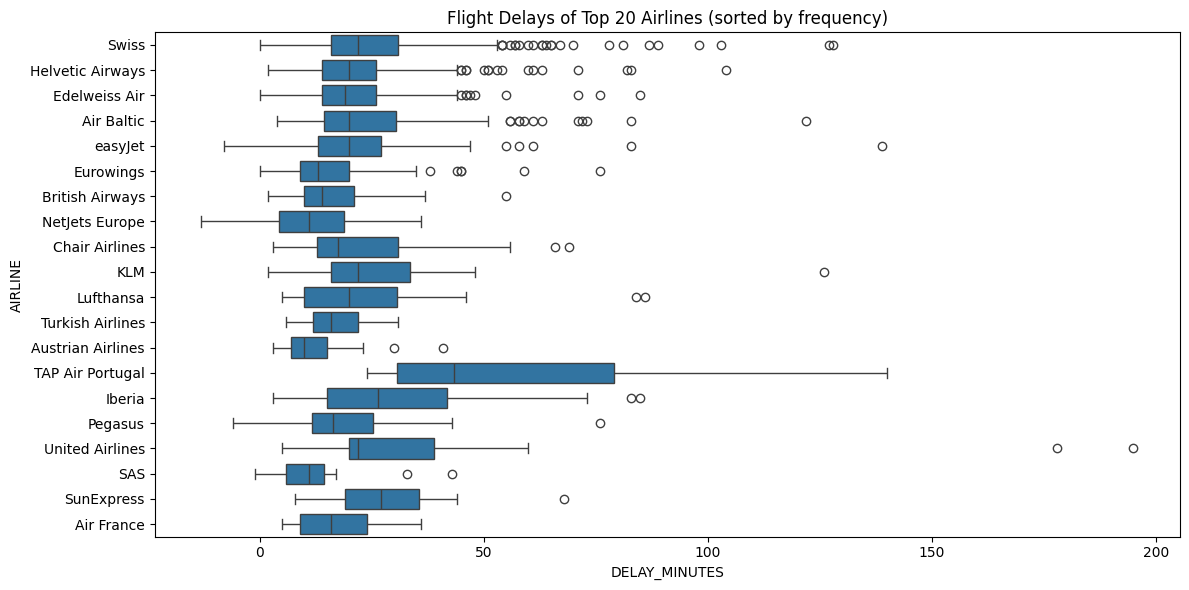

In [11]:
# 1. Die 20 meistvertretenen Airlines finden (inkl. Reihenfolge)
top_airline_counts = zrh_flightdelay["AIRLINE"].value_counts().nlargest(20)
top_airlines = top_airline_counts.index

# 2. DataFrame auf diese Airlines beschränken
df_top = zrh_flightdelay[zrh_flightdelay["AIRLINE"].isin(top_airlines)]

# 3. Boxplot zeichnen mit sortierten Airlines
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top,
    x="DELAY_MINUTES",
    y="AIRLINE",
    order=top_airlines  # Sortiere nach Häufigkeit
)
plt.xticks(rotation=0)
plt.title("Flight Delays of Top 20 Airlines (sorted by frequency)")
plt.tight_layout()
plt.show()


## Top 20 most frequent destinations from ZRH

In [12]:
# Anzahl der Flüge pro Destination (Top 20)
top_destination_counts = zrh_flightdelay["DESTINATION"].value_counts().nlargest(20)

# Ausgabe anzeigen
print(top_destination_counts)


DESTINATION
London               128
Berlin                68
Amsterdam             68
Frankfurt             65
Palma de Mallorca     56
Paris                 48
Vienna                48
Madrid                46
Hamburg               46
Istanbul              45
Geneva                44
Rome                  42
Barcelona             39
Dusseldorf            38
Lisbon                36
Copenhagen            36
Munich                35
Belgrade              35
Athens                34
Pristina              32
Name: count, dtype: int64


## Flight delays for the top destinations

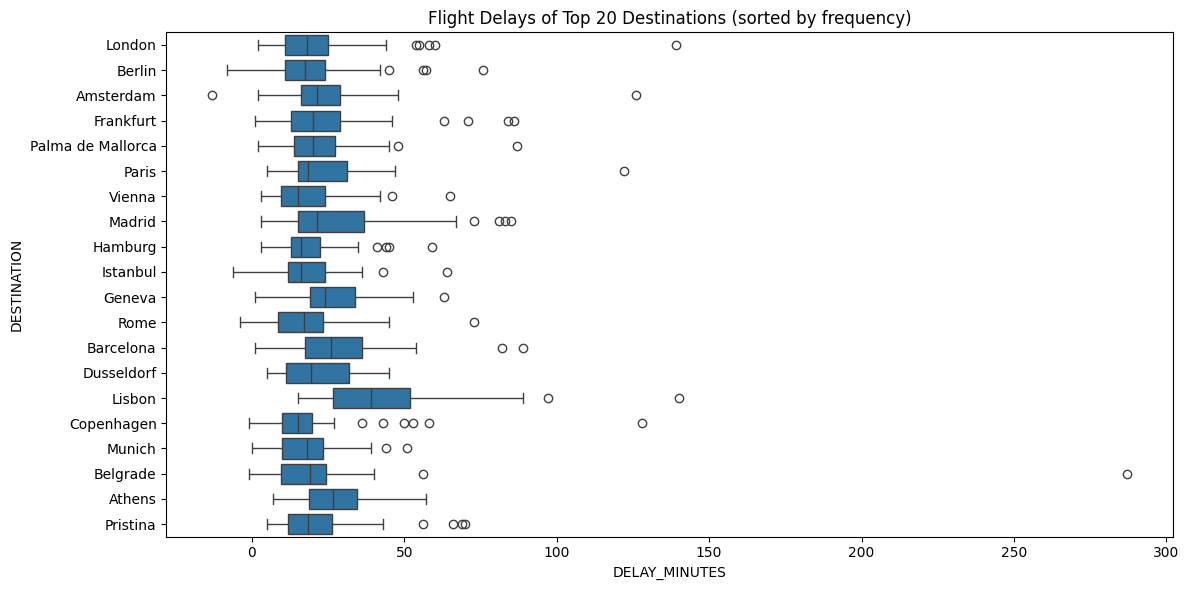

In [13]:
# 1. Die 20 meistvertretenen Destinationen finden (inkl. Reihenfolge nach Häufigkeit)
top_dest_counts = zrh_flightdelay["DESTINATION"].value_counts().nlargest(20)
top_destinations = top_dest_counts.index

# 2. DataFrame auf diese Destinationen beschränken
df_top_dest = zrh_flightdelay[zrh_flightdelay["DESTINATION"].isin(top_destinations)]

# 3. Boxplot zeichnen mit sortierten Kategorien
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top_dest,
    x="DELAY_MINUTES",
    y="DESTINATION",
    order=top_destinations  # Sortierung nach Häufigkeit
)
plt.xticks(rotation=0)
plt.title("Flight Delays of Top 20 Destinations (sorted by frequency)")
plt.tight_layout()
plt.show()


## Create new numeric columns for DESTINATION, AIRLINE, and AIRCRAFT

In [14]:
# Destination in numerische Codes umwandeln
zrh_flightdelay["DEST_CODE"] = zrh_flightdelay["DESTINATION"] \
    .astype("category") \
    .cat.codes

# Airline in numerische Codes umwandeln
zrh_flightdelay["AIRLINE_CODE"] = zrh_flightdelay["AIRLINE"] \
    .astype("category") \
    .cat.codes

# Aircraft in numerische Codes umwandeln
zrh_flightdelay["AIRCRAFT_CODE"] = zrh_flightdelay["AIRCRAFT"] \
    .astype("category") \
    .cat.codes

# Kontrolle
print(zrh_flightdelay[["DESTINATION","DEST_CODE",
                       "AIRLINE","AIRLINE_CODE",
                       "AIRCRAFT","AIRCRAFT_CODE"]].head(50))


          DESTINATION  DEST_CODE           AIRLINE  AIRLINE_CODE AIRCRAFT  \
0             Larnaca         90     Edelweiss Air            35     A320   
1            Pristina        140    Chair Airlines            27     A319   
2               Olbia        127     Edelweiss Air            35     A320   
3            Pristina        140     Edelweiss Air            35     A359   
4              Madrid        101  Helvetic Airways            58     E295   
5            Belgrade         16             Swiss            93     BCS3   
6              London         96             Swiss            93     BCS1   
7   Palma de Mallorca        131             Swiss            93     A321   
8            Brindisi         29             Swiss            93     A320   
9            Hurghada         75    Chair Airlines            27     A320   
10            Funchal         63     Edelweiss Air            35     A320   
11             Bilbao         20     Edelweiss Air            35     A320   

In [15]:
zrh_flightdelay.head(50)

,DESTINATION,IATA_CODE,AIRLINE,AIRCRAFT,DATETIME,DEPART_TIME,DEPART_DATETIME,DELAY_MINUTES,WEATHER,TEMP,DEST_CODE,AIRLINE_CODE,AIRCRAFT_CODE
0,Larnaca,LCA,Edelweiss Air,A320,2025-04-28 05:45:00,06:02,2025-04-28 06:02:00,17,5,5.4,90,35,3
1,Pristina,PRN,Chair Airlines,A319,2025-04-28 05:45:00,06:00,2025-04-28 06:00:00,15,5,5.4,140,27,2
2,Olbia,OLB,Edelweiss Air,A320,2025-04-28 06:25:00,06:45,2025-04-28 06:45:00,20,5,6.4,127,35,3
3,Pristina,PRN,Edelweiss Air,A359,2025-04-28 06:30:00,06:38,2025-04-28 06:38:00,8,5,6.4,140,35,8
4,Madrid,MAD,Helvetic Airways,E295,2025-04-28 06:55:00,07:13,2025-04-28 07:13:00,18,5,6.4,101,58,45
5,Belgrade,BEG,Swiss,BCS3,2025-04-28 06:55:00,07:14,2025-04-28 07:14:00,19,5,6.4,16,93,24
6,London,LCY,Swiss,BCS1,2025-04-28 06:55:00,07:34,2025-04-28 07:34:00,39,5,6.4,96,93,23
7,Palma de Mallorca,PMI,Swiss,A321,2025-04-28 06:50:00,07:11,2025-04-28 07:11:00,21,5,6.4,131,93,4
8,Brindisi,BDS,Swiss,A320,2025-04-28 06:50:00,07:17,2025-04-28 07:17:00,27,5,6.4,29,93,3
9,Hurghada,HRG,Chair Airlines,A320,2025-04-28 06:45:00,06:52,2025-04-28 06:52:00,7,5,6.4,75,27,3


## Save the DataFrame to a CSV file for training

In [16]:
# Speichern des DataFrames als CSV-Datei
zrh_flightdelay.to_csv("zrh_flightdelay.csv", index=False)